## Homework 1: Web Scrapping
#### By Avihai Serfati and Dvir Simchon

In [1]:
from bs4 import BeautifulSoup
import mwparserfromhell
import pandas as pd
import re
from urllib.request import urlopen
from urllib.parse import urlencode

<h2>Gal Gadot</h2>
<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimages.saatchiart.com%2Fsaatchi%2F419538%2Fart%2F6372255%2F5442015-FZIICMKV-7.jpg&f=1&nofb=1" height="100px" style="margin-left: 0px"></img>

In [2]:
API_URL = "https://en.wikipedia.org/w/api.php"
wiki_prefix = "https://en.wikipedia.org"
wiki_gal = 'https://en.wikipedia.org/wiki/Gal_Gadot'
html = urlopen(wiki_gal)
soup = BeautifulSoup(html, features='html.parser')
films_table = soup.find('table', class_='wikitable sortable').findAll('tr') 

In [3]:
headers = films_table[0]
rows = films_table[1:]
headers = [header.get_text().strip() for header in headers.find_all('th')]
table = [[cell.get_text().strip() for cell in row.find_all('td')]
         for row in rows]

In [4]:
for i, v in enumerate(table):
    if not v[0].isdigit() and v[0] != 'TBA':
        table[i].insert(0, table[i-1][0])

In [5]:
df = pd.DataFrame(data=table, columns=headers)
df = df.drop(['Notes'], axis=1)
pd.set_option('display.max_columns', 5)
df

,Year,Title,Role,Director(s)
0,2009,Fast & Furious,Gisele Yashar,Justin Lin
1,2010,Date Night,Natanya,Shawn Levy
2,2010,Knight and Day,Naomi,James Mangold
3,2011,Fast Five,Gisele Yashar,Justin Lin
4,2013,Fast & Furious 6,Gisele Yashar,Justin Lin
5,2014,Kicking Out Shoshana,Mirit Ben Harush,Shay Kanot
6,2015,Furious 7,Gisele Yashar,James Wan
7,2016,Batman v Superman: Dawn of Justice,Diana Prince / Wonder Woman,Zack Snyder
8,2016,Criminal,Jill Pope,Ariel Vromen
9,2016,Keeping Up with the Joneses,Natalie Jones,Greg Mottola


In [6]:
import unicodedata2
def strip_accents(text):
    return ''.join(char for char in
                   unicodedata2.normalize('NFKD', text)
                   if unicodedata2.category(char) != 'Mn')

In [7]:
import json
def parse(title):
    data = {"action": "query", "prop": "revisions", "rvprop": "content",
            "rvslots": "main", "rvlimit": 1, "titles": title,
            "format": "json", "formatversion": "2"}
    raw = urlopen(API_URL, urlencode(data).encode()).read()
    res = json.loads(raw)
    revision = res["query"]["pages"][0]["revisions"][0]
    text = revision["slots"]["main"]["content"]
    return mwparserfromhell.parse(text)

In [8]:
def find_number_of_awards(page_actor):
    try:
        page = urlopen(page_actor)
        page_actor = BeautifulSoup(page, 'html.parser')
        awards1 = awards2 = awards3 = -1
    except:
        return 0
    try:
        awards1 = len(
            page_actor.find('span', {'id': 'Awards_and_nominations'}).findNext('table').find_all('td', {
                'class': 'yes table-yes2'}))
    except:
        pass
    try:
        awards2 = len(page_actor.find('span', {'id': 'Awards_and_nominations'}).findNext('table').findNext('table').find_all('td', {
            'class': 'yes table-yes2'}))
    except:
        pass
    try:
        url = page_actor.find('a', {'title': re.compile(
            'List of awards and nominations received by')})['href']
        page_awards = BeautifulSoup(
            urlopen(wiki_prefix + url), "lxml")
        awards3 = len(page_awards.findAll(
            'td', {'class': 'yes table-yes2'}, text=re.compile("Won")))
    except:
        pass
    if awards1 != -1 or awards2 != -1 or awards3 != -1:
        return max(awards1, awards2, awards3)
    return 0

In [9]:
page = urlopen(wiki_gal)
soup = BeautifulSoup(page, 'html.parser')
films_table = soup.find('table', class_='wikitable sortable')
films_urls = [wiki_prefix+row.find(href=True)['href']
              for row in films_table.findAll('tr') if row.find_all('td')]

In [10]:
actors_table = []
for url in films_urls:
    film_actors = []
    soup = BeautifulSoup(urlopen(url), features='html.parser')
    raw = (soup.find(id=re.compile(
        ".*cast.*", re.IGNORECASE)).parent).find_next('ul')
    film_actors.extend([[i.find('a').text, wiki_prefix+i.find(href=True)['href']]
                        for i in raw.select("li") if i.find('a') and i.find('a').text != 'Gal Gadot'])
    actors_table.extend(film_actors)
    # if len(actors_table) > 7:
    #     break

# for v in actors_table: v[0] = strip_accents(v[0])

In [11]:
# extract birth year from birth date string
def infobox(name):
    year = -1
    country = 'U.S.'
    wiki = ''
    try:
        wiki = parse(name.strip())
    except:
       return [year, country]
    try:
        info_box = wiki.filter_templates(matches="Infobox")[0]
        year = int(''.join(info_box.get('birth_date').value.filter_templates()[0].get(1)))
    except:
            try:
                by = info_box.get('birth_date').value
                by = re.match(r'.*([1-3][0-9]{3})', str(by))
                year = int(by.group(1))
            except:
                    try:
                        info_box = wiki.filter_templates(matches='birth date')[0]
                        year = int(str(info_box.get(1).value))
                    except:
                        pass
    try:
        info_box = wiki.filter_templates(matches="Infobox")[0]
        country_raw = info_box.get('birth_place').value
        j = country_raw.rfind(']')
        d = ",!?/&-:;@'<>{}"
        country_raw = re.split("["+"\\".join(d)+"]", country_raw[j+2:])
        country_raw = ['U.S.', country_raw[0].strip()][country_raw[0].strip() != '']
        country = country_raw
    except:
        pass
    return [year, country]

In [12]:
from tqdm import tqdm
for v in tqdm(actors_table):
    name, url = v
    v.extend(infobox(name))
    v.append(find_number_of_awards(url))


100%|██████████| 190/190 [05:24<00:00,  1.71s/it]


In [13]:
df = pd.DataFrame(data=actors_table, columns=['Name','url', 'Year of Birth', 'Country of Birth','No. of Awards'])
df = df.drop(['url'], axis=1)
pd.set_option('display.min_rows', 30)
actors = df.drop_duplicates()
actors

,Name,Year of Birth,Country of Birth,No. of Awards
0,Vin Diesel,1967,U.S.,8
1,Paul Walker,1973,U.S.,3
2,Michelle Rodríguez,-1,U.S.,8
3,Jordana Brewster,1980,Panama,1
4,John Ortiz,1968,U.S.,0
5,Laz Alonso,1974,U.S.,0
6,Steve Carell,1962,U.S.,24
7,Tina Fey,1970,U.S.,40
8,Mark Wahlberg,1971,U.S.,8
9,Taraji P. Henson,1970,U.S.,33


In [14]:
actors.loc[df['Year of Birth'] == -1]

,Name,Year of Birth,Country of Birth,No. of Awards
2,Michelle Rodríguez,-1,U.S.,8
15,Common,-1,U.S.,21
33,Falk Hentschel,-1,U.S.,0
42,"Chris ""Ludacris"" Bridges",-1,U.S.,16
64,Cody Walker,-1,U.S.,0
94,Natalie Burn,-1,Ukraine,0
119,Lilly Aspell,-1,U.S.,0
135,Ray Fisher,-1,U.S.,0
157,Ryan Gaul,-1,U.S.,0
158,Edi Patterson,-1,U.S.,0


<Figure size 1152x648 with 0 Axes>

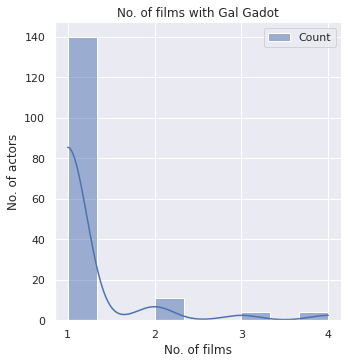

In [15]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
sns.set()
dfh = df.groupby('Name').count()
sns.displot(dfh["Year of Birth"], label="Count",kde=True)
plt.xlabel('No. of films')
plt.ylabel('No. of actors')
plt.xticks([1,2,3,4])
plt.title("No. of films with Gal Gadot")
plt.legend()  
plt.show()